# Equity Index PCA and Reconstruction

Whitney Rueckl <br>
Summer  2022

In [60]:
import os
import sys
#sys.version

import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.max_rows = 10
#from datetime import datetime
import missingno as msno

import matplotlib.pyplot as plt

from sklearn.decomposition import KernelPCA, PCA

import quandl
quandl.ApiConfig.api_key = '<enter_quandl_key_here>'

# View all databases and codes
#https://www.quandl.com/api/v3/databases?api_key=<enter_quandl_api_key_here> #&page=2

# from alpha_vantage.timeseries import TimeSeries
# alpha_vantage_api_key = '<enter_alpha_vantage_key>'

In [ ]:
#get https://www.quandl.com/api/v3/datasets?database_code=<database-name>&api_key=<api-key>

### Get historical price data

#### Historical data for the sector ETFs of the S&P 500 (SPY)

In [19]:
tickers = [
    'XLY',
    'XLP',
    'XLE',
    'XLF',
    'XLV',
    'XLI',
    'XLB',
    'XLRE',
    'XLK',
    'XLU'
]

In [20]:
df_components = pdr.get_data_yahoo(tickers, start='2017-01-01', end='2017-12-31') # note: returns dataframe with a MultiIndex...revisit this
df_components = df_components['Adj Close']
df_components.columns = df_components.columns.str.replace(' ','_')

In [21]:
#df_components

In [22]:
df_components.columns = tickers
df_components.head(10)

,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLRE,XLK,XLU
Date,,,,,,,,,,
2017-01-03,77.117432,44.767738,58.816734,21.115057,63.650330,56.652653,44.827702,25.801811,45.620102,40.556461
2017-01-04,78.144035,44.767738,58.693192,21.285702,64.151588,56.987553,45.482327,26.127998,45.779057,40.707127
2017-01-05,78.087509,44.914391,58.546474,21.070150,64.479675,56.824631,45.347805,26.261810,45.853859,40.748981
2017-01-06,78.473671,44.957512,58.600525,21.142004,64.661934,57.150478,45.392651,26.261810,46.190464,40.874546
2017-01-09,78.407745,44.595226,57.751141,20.998299,64.935364,56.706955,45.383690,26.094543,46.181122,40.338814
2017-01-10,78.690300,44.370968,57.226044,21.043205,65.163216,56.942295,45.410576,25.768356,46.190464,40.213253
2017-01-11,78.859802,44.457226,57.843792,21.177927,64.507034,57.240990,45.778233,25.626177,46.405529,40.631790
2017-01-12,78.784470,44.414089,57.604404,20.998299,64.570808,57.005642,45.688576,25.726538,46.293320,40.665279
2017-01-13,79.076439,44.439968,57.434528,21.115057,64.634613,57.222885,45.616840,25.667995,46.433571,40.606674


#### Fill any missing values (forward fill)

In [23]:
filled_df_components = df_components.fillna(method='ffill')
#filled_df_components

In [24]:
daily_df_components = filled_df_components.resample('24h').ffill()
#daily_df_components

In [25]:
#daily_df_components = daily_df_components.fillna(method='bfill')

#### Get historical price data for the S&P 500<br>

In [26]:
df_index = pdr.get_data_yahoo("SPY", start='2017-01-01', end='2017-12-31')
df_index

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,225.830002,223.880005,225.039993,225.240005,91366500.0,204.625153
2017-01-04,226.750000,225.610001,225.619995,226.580002,78744400.0,205.842514
2017-01-05,226.580002,225.479996,226.270004,226.399994,78379000.0,205.679001
2017-01-06,227.750000,225.899994,226.529999,227.210007,71559900.0,206.414871
2017-01-09,227.070007,226.419998,226.910004,226.460007,46939700.0,205.733505
...,...,...,...,...,...,...
2017-12-22,267.640015,266.899994,267.600006,267.510010,78720900.0,247.751175
2017-12-26,267.440002,266.890015,267.049988,267.190002,45244400.0,247.454803
2017-12-27,267.730011,267.010010,267.380005,267.320007,57751000.0,247.575256


In [27]:
# Convert columns to snake case (my preference)
df_index.columns = df_index.columns.str.lower().str.replace(' ','_')

# Grab the adjusted close prices only
df_index = pd.DataFrame(df_index['adj_close'])
df_index

,adj_close
Date,
2017-01-03,204.625153
2017-01-04,205.842514
2017-01-05,205.679001
2017-01-06,206.414871
2017-01-09,205.733505
...,...
2017-12-22,247.751175
2017-12-26,247.454803
2017-12-27,247.575256


In [28]:
# Check the type on date indexes both datasets
print(type(df_index.index[0]))
print(type(df_components.index[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [29]:
# Resample on a daily basis
df_index = df_index.resample('24h').ffill()

## Applying a Kernal PCA

About kernal PCA: <br>
https://nirpyresearch.com/pca-kernel-pca-explained/ <br>
https://ml-explained.com/blog/kernel-pca-explained <br> https://en.wikipedia.org/wiki/Kernel_principal_component_analysis#Introduction_of_the_Kernel_to_PCA <br>
https://towardsdatascience.com/kernel-pca-vs-pca-vs-ica-in-tensorflow-sklearn-60e17eb15a64 <br>
https://www.youtube.com/watch?v=wBVSbVktLIY <br>

A normal PCA relies on linear transformations (the process of matrix decomposition into eigenvectors is a linear transformation).  As a result, the principal components are a linear combination of the original features. The kernal PCA was developed to deal with non-linearity in a dataset.

Say that $\mathbf{x}$ the original set of n variables, let’s call $\phi(\mathbf{x})$ the non-linear combination (mapping) of these variables into a m>n dataset. Now we can compute the kernel function (which in practice is an array):

$$\kappa(\mathbf{x}) = \phi(\mathbf{x})\phi^{T}(\mathbf{x})$$

It turns out that the kernel function plays the same role as the covariance matrix did in linear PCA. This means that we can calculate the eigenvalues and eigenvectors of the kernel matrix and these are the new principal components of the m-dimensional space where we mapped our original variables into.

The kernel trick is called this way because the kernel function (matrix) enables us to get to the eigenvalues and eigenvector without actually calculating $\phi(\mathbf{x})$ explicitly. This is the step that would blow up the number of variables and we can circumvent it using the kernel trick.

#### Summary of kernal PCA:
1. Construct the kernel matrix $K$ from the training dataset
$$K_{i,j} =  \kappa\left(\mathbf{x}_{\mathbf{i}}, \mathbf{x}_{\mathbf{j}}\right)$$

2. If the projected matrix does not have zero mean, use the Gram matrix $\tilde{K}$ to substitute the kernel matrix $K$. <br>
$$
\tilde{K}=K-\mathbf{1}_{\mathbf{N}} K-K \mathbf{1}_{\mathbf{N}}+\mathbf{1}_{\mathbf{N}} K \mathbf{1}_{\mathbf{N}}
$$

3. Use $K_{a_{k}}=\lambda_{k} N_{a_{k}}$ to solve for the vector $a_{i}$.

<br>

4. Compute the kernel principal components $y_{k}(x)$
$$
y_{k}(\mathbf{x})=\phi(\mathbf{x})^{T} \mathbf{v}_{k}=\sum_{i=1}^{N} a_{k i} \kappa\left(\mathbf{x}_{\mathbf{i}}, \mathbf{x}_{\mathbf{j}}\right)
$$

### Normalize the data
For PCA, the data must be normalized. Do this with z-scoring

In [30]:
fn_z_score = lambda x: (x - x.mean()) / x.std()
df_z_components = daily_df_components.apply(lambda x: (x - x.mean()) / x.std())

In [61]:
#df_z_components.iloc[0].std()

### Fit a Kernel PCA and Plot Eigenvalues

In [31]:
# Note that a kernal PCA with a linear kernal is equivalent to a regular PCA
fitted_kpca = KernelPCA(kernel = 'linear').fit(df_z_components)
fitted_kpca

KernelPCA()

In [32]:
#help(KernelPCA())
fitted_kpca.eigenvalues_

array([2.77470369e+03, 4.86045838e+02, 1.82263457e+02, 7.31877015e+01,
       3.23057447e+01, 2.16507149e+01, 1.56319660e+01, 6.92309111e+00,
       4.52014479e+00, 2.76764895e+00])

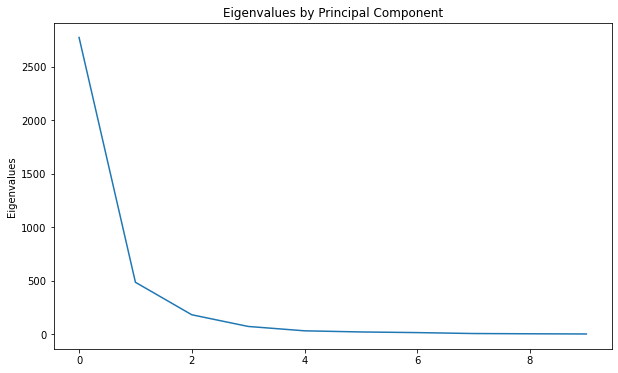

In [34]:
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(fitted_kpca.eigenvalues_)
plt.ylabel('Eigenvalues')
plt.title("Eigenvalues by Principal Component")
plt.show()

From the graph above, we can see that the first few components explain most of the variance in the dataset. <br>



### %  of explained variance by the first N components
Take the first <font color='blue'>N</font> eigenvalues, and see how much explanation each of these eigenvalues gives. We do this by calculating their weighted average values. This will tell us the % of total variance explained by each of the first <font color='blue'>N</font> principal components.

In [36]:
N = 4
fn_weighted_avg = lambda x: x / x.sum()
weighted_values = fn_weighted_avg(fitted_kpca.eigenvalues_)[:N]

print("The % of total variance explained by the first N components is: ", '\n' + str(weighted_values))

The % of total variance explained by the first N components is:  
[0.77075103 0.13501273 0.05062874 0.02032992]


The output above tells us that ~77.1% of the total variance in the dataset is explained by the first principal component, ~13.5% by the second principal component, and so on. 

In [38]:
weighted_values.sum()

0.9767224137602034

The first five eigenvalues explain 97% of the variance in the dataset

## Reconstructing the Index using PCA

#### Create a PCA index with four components:

In [40]:
#del kernel_pca, df_combined, reconstructed_values

In [49]:
kernel_pca

KernelPCA(n_components=4)

In [45]:
N = 4
kernel_pca = KernelPCA(kernel = 'linear', n_components=N).fit(df_z_components)
pca_N = kernel_pca.transform(daily_df_components)
pca_N

array([[134.48618224,  50.19444141,  38.78396359, -15.458976  ],
       [135.63008693,  50.32444341,  38.81980905, -15.30091699],
       [135.68969048,  49.99170269,  38.77503105, -15.41092841],
       ...,
       [163.87509437,  53.05276173,  42.17047144, -10.04627376],
       [164.31163102,  53.20831257,  42.06068287, -10.14148712],
       [163.73989349,  52.95071271,  41.94037881, -10.32172231]])

In [46]:
weights = fn_weighted_avg(kernel_pca.eigenvalues_)
reconstructed_values = np.dot(pca_N, weights)
#reconstructed_values

In [47]:
# Combine DJIA and PCA index for comparison
df_combined = df_index.copy()
df_combined['pca_N'] = reconstructed_values
df_combined = df_combined.apply(fn_z_score)

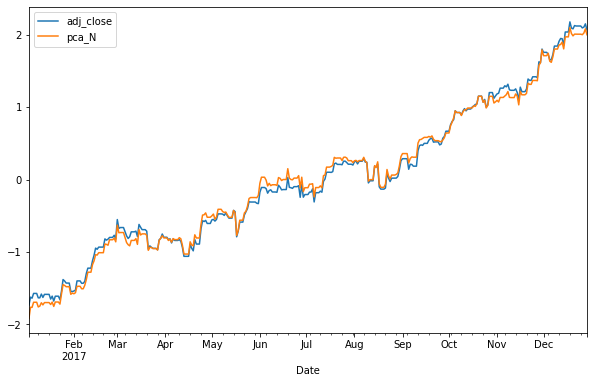

In [48]:
df_combined.plot(figsize=(10, 6));

#### A kernel PCA using a linear kernel function same as regular PCA? (Yes)

Note: A kernel PCA using a linear kernel function is the same as a standard PCA. <br>
The eigenvalues and eigenvectors will be different but the principal components will not change between a standard PCA and a kernel PCA with a linear kernel. 

https://stats.stackexchange.com/questions/101344/is-kernel-pca-with-linear-kernel-equivalent-to-standard-pca#:~:text=Summary%3A%20kernel%20PCA%20with%20linear,equivalent%20to%20the%20standard%20PCA.

In [50]:
fitted_pca = PCA().fit(df_z_components)
# get eigenvalues with .explained_variance_
fitted_pca.explained_variance_

# from numpy.linalg import eig
# cov_matrix = np.cov(df_z_components.T)
# eigvals, eigvecs = eig(cov_matrix)

array([7.70751026e+00, 1.35012733e+00, 5.06287380e-01, 2.03299171e-01,
       8.97381798e-02, 6.01408746e-02, 4.34221278e-02, 1.92308086e-02,
       1.25559578e-02, 7.68791374e-03])

In [53]:
from numpy.linalg import eig
cov_matrix = np.cov(df_z_components.T)
eigvals, eigvecs = eig(cov_matrix)
print(eigvals, eigvecs)

[7.70751026e+00 1.35012733e+00 5.06287380e-01 2.03299171e-01
 8.97381798e-02 6.01408746e-02 4.34221278e-02 1.92308086e-02
 7.68791374e-03 1.25559578e-02] [[ 0.3397903  -0.0473542   0.37861315  0.01635189  0.48471152 -0.31930581
   0.25057229 -0.31124546 -0.28350305  0.40218054]
 [ 0.26263785  0.33170614  0.77880063 -0.09042452 -0.28648779  0.16139062
  -0.15842688  0.13031476  0.00364619 -0.23678869]
 [-0.09344757 -0.80010317  0.24489937 -0.39405487 -0.16276413  0.0587656
  -0.2778692  -0.15444492  0.00397523  0.06943805]
 [ 0.31909276 -0.33660046 -0.0089594   0.37047726 -0.20730952  0.52474642
   0.56255545 -0.04035969 -0.06896589 -0.079727  ]
 [ 0.34482588  0.06988986 -0.22243761  0.28140596 -0.4817661  -0.2229585
  -0.36892773 -0.5531948  -0.15313759  0.01226251]
 [ 0.3495514  -0.15127821  0.02398824  0.28028656 -0.04062534 -0.16680911
  -0.16861745  0.38079801  0.63281312  0.41524164]
 [ 0.34172086 -0.23000581 -0.14489129  0.10528088  0.134015   -0.19310885
  -0.24065359  0.5590575

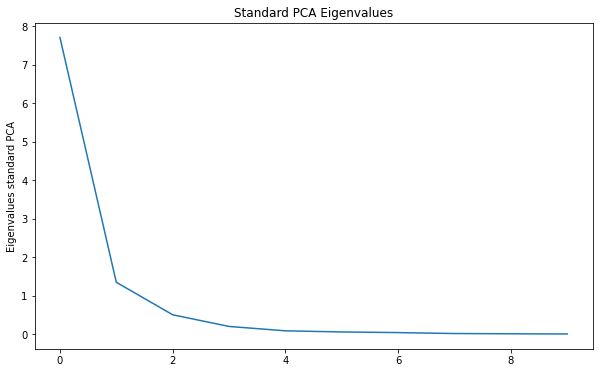

In [54]:
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(fitted_pca.explained_variance_)
plt.ylabel('Eigenvalues standard PCA')
plt.title('Standard PCA Eigenvalues')
plt.show()